W207 Project Team:

George Jiang, Kineret Stanley and John Woolley

Apr 16, 2020

UC Berkeley MIDS

#Premise

In this Kaggle competition, we seek to train a classifier model to determine whether someone is able to repay a loan for which they have applied given their current application, previous applications, and other historical payment and credit information.

The metric used for the competition is Area Under the Curve (AUC), which will be used to evaluate the performance of models during development and final testing.

Source: https://www.kaggle.com/c/home-credit-default-risk/overview

# Setup 

In [ ]:
import os
import sys 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE 
import gc

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#mount from Google Drive 

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  path = r'/content/drive/MyDrive/MIDS_w207_final_project'
except ModuleNotFoundError:
  path = r'data'


In [ ]:
# notebook settings
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.4f}'.format

df = pd.read_csv(os.path.join(path,'application_train.csv'))
bureau = pd.read_csv(os.path.join(path,'bureau.csv'))
prev_app = pd.read_csv(os.path.join(path,'previous_application.csv'))
print("app_train data holds {} obs and {} variables".format(df.shape[0], df.shape[1]))
print("bureau data holds {} obs and {} variables".format(bureau.shape[0], bureau.shape[1]))
print("prev_app data holds {} obs and {} variables".format(prev_app.shape[0], prev_app.shape[1]))

app_train data holds 307511 obs and 122 variables
bureau data holds 1716428 obs and 17 variables
prev_app data holds 1670214 obs and 37 variables


#Modify features based on EDA (separate document)


In [ ]:
# Referenced https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_OVERDUE'][bureau['AMT_CREDIT_SUM_OVERDUE'] < 0] = np.nan
bureau['AMT_ANNUITY'][bureau['AMT_ANNUITY'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_LIMIT'][bureau['AMT_CREDIT_SUM_LIMIT'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_DEBT'][bureau['AMT_CREDIT_SUM_DEBT'] < 0] = np.nan
bureau['AMT_CREDIT_SUM'][bureau['AMT_CREDIT_SUM'] < 0] = np.nan
bureau['AMT_CREDIT_MAX_OVERDUE'][bureau['AMT_CREDIT_MAX_OVERDUE'] < 0] = np.nan
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] > 0] = np.nan
prev_app['AMT_DOWN_PAYMENT'][prev_app['AMT_DOWN_PAYMENT'] < 0] = np.nan
prev_app['DAYS_FIRST_DRAWING'][prev_app['DAYS_FIRST_DRAWING'] > 0] = np.nan
prev_app['DAYS_FIRST_DUE'][prev_app['DAYS_FIRST_DUE'] > 0] = np.nan
prev_app['DAYS_LAST_DUE_1ST_VERSION'][prev_app['DAYS_LAST_DUE_1ST_VERSION'] > 0] = np.nan
prev_app['DAYS_LAST_DUE'][prev_app['DAYS_LAST_DUE'] > 0] = np.nan
prev_app['DAYS_TERMINATION'][prev_app['DAYS_TERMINATION'] > 0] = np.nan
prev_app['SELLERPLACE_AREA'][prev_app['SELLERPLACE_AREA'] < 0] = np.nan

# Add New Features

## Previous Application Features

Using our domain knowledge, we first created some flags that will be used to create new features later on, see below. 

In [ ]:
# Create new features - a bit of one hot coding 
prev_app['APPROVED'] = prev_app['NAME_CONTRACT_STATUS']=='Approved'
prev_app['REFUSED'] = prev_app['NAME_CONTRACT_STATUS']=='Refused'
prev_app['HIGH_INTEREST'] = prev_app['NAME_YIELD_GROUP']=='high'
prev_app['LOW_INTEREST'] = prev_app['NAME_YIELD_GROUP'].isin(['low_normal','low_action'])
prev_app['NEW'] = prev_app['NAME_CLIENT_TYPE'].isin(['New'])
prev_app['REPEAT'] = prev_app['NAME_CLIENT_TYPE'].isin(['Repeater','Refreshed'])

sum, mean, min, and max were used to create new features, because they capture different dimensions of the same features, see below.

In [ ]:
df_agg = copy.deepcopy(df)

prev_new_features = (prev_app.groupby('SK_ID_CURR', as_index=False)
             .agg(PRE_APP_COUNT=('SK_ID_PREV','count'),
                  APPROVED_LOAN_COUNT=('APPROVED','sum'),
                  REFUSED_LOAN_COUNT= ('REFUSED', 'sum'),
                  LOW_INTEREST_COUNT = ('LOW_INTEREST', 'sum'),
                  HIGH_INTEREST_COUNT = ('HIGH_INTEREST', 'sum'),
                  REPEAT_LOAN_COUNT = ('REPEAT','sum'),
                  REJECT_REASON_COUNT = ('CODE_REJECT_REASON', 'nunique'),
                  TOTAL_PRODUCT_COMBO = ('PRODUCT_COMBINATION', 'nunique'),
                  TOTAL_PMT_CNT=('CNT_PAYMENT','sum'),
                  AVG_PMT_CNT=('CNT_PAYMENT','mean'),
                  MIN_PMT_CNT=('CNT_PAYMENT','min'),
                  MAX_PMT_CNT=('CNT_PAYMENT','max'),
                  AVG_DAYS_OF_PRE_DEC = ('DAYS_DECISION', 'mean'),
                  MIN_DAYS_OF_PRE_DEC = ('DAYS_DECISION', 'min'),
                  MAX_DAYS_OF_PRE_DEC = ('DAYS_DECISION', 'max'),
                  AVG_INT = ('RATE_INTEREST_PRIVILEGED', 'mean'),
                  MIN_INT = ('RATE_INTEREST_PRIVILEGED', 'min'),
                  MAX_INT = ('RATE_INTEREST_PRIVILEGED', 'max'),
                  AVG_DOWN_PMT = ('RATE_DOWN_PAYMENT','mean'),
                  MIN_DOWN_PMT = ('RATE_DOWN_PAYMENT','min'),
                  MAX_DOWN_PMT = ('RATE_DOWN_PAYMENT','max'),
                  NEW_LOAN_COUNT = ('NEW', 'sum'),
                  AVG_SELLERPLACE = ('SELLERPLACE_AREA', 'mean'),
                  MIN_SELLERPLACE = ('SELLERPLACE_AREA', 'max'),
                  MAX_SELLERPLACE = ('SELLERPLACE_AREA', 'min'),
                  AVG_DAYS_TERMINATION = ('DAYS_TERMINATION', 'mean'),
                  MIN_DAYS_TERMINATION = ('DAYS_TERMINATION', 'min'),
                  MAX_DAYS_TERMINATION = ('DAYS_TERMINATION', 'max'),
                  AVG_DAYS_LAST_DUE = ('DAYS_LAST_DUE', 'mean'),
                  MIN_DAYS_LAST_DUE = ('DAYS_LAST_DUE', 'min'),
                  MAX_DAYS_LAST_DUE = ('DAYS_LAST_DUE', 'max'),
                  AVG_AMT_DOWN_PAYMENT = ('AMT_DOWN_PAYMENT', 'mean'),
                  MIN_AMT_DOWN_PAYMENT = ('AMT_DOWN_PAYMENT', 'min'),
                  MAX_AMT_DOWN_PAYMENT = ('AMT_DOWN_PAYMENT', 'max')
                 )
            )

df_agg = df_agg.merge(prev_new_features, on = ['SK_ID_CURR'], how = 'left')


Ratio is used as features, because it captures the interaction between new features and normalize some features for additional information, see below.

In [ ]:
df_agg['APPROVED_RATIO'] = df_agg['APPROVED_LOAN_COUNT']/df_agg['PRE_APP_COUNT']
df_agg['REFUSED_RATIO'] = df_agg['REFUSED_LOAN_COUNT']/df_agg['PRE_APP_COUNT']
df_agg['APPROVE_REFUSE_RATIO'] = df_agg['APPROVED_LOAN_COUNT']/df_agg['REFUSED_LOAN_COUNT']

df_agg['LOW_INT_RATIO'] = df_agg['LOW_INTEREST_COUNT']/df_agg['PRE_APP_COUNT']
df_agg['HIGH_INT_RATIO'] = df_agg['HIGH_INTEREST_COUNT']/df_agg['PRE_APP_COUNT']
df_agg['LOW_HIGH_INT_RATIO'] = df_agg['LOW_INTEREST_COUNT']/df_agg['HIGH_INTEREST_COUNT']

df_agg['NEW_RATIO'] = df_agg['NEW_LOAN_COUNT']/df_agg['PRE_APP_COUNT']
df_agg['REPEAT_RATIO'] = df_agg['REPEAT_LOAN_COUNT']/df_agg['PRE_APP_COUNT']
df_agg['NEW_REPEAT_RATIO'] = df_agg['NEW_LOAN_COUNT']/df_agg['REPEAT_LOAN_COUNT']

In [ ]:
# Feature: MAX Approved Credit
subset_1 = prev_app[prev_app['APPROVED']==1]
g_1 = subset_1.groupby(['SK_ID_CURR']).agg(MAX_APPROVED_CREDIT = ("AMT_CREDIT",'max'))
df_agg = df_agg.merge(g_1, on = ['SK_ID_CURR'], how = 'left')
df_agg.MAX_APPROVED_CREDIT.fillna(0, inplace=True)

## Bureau Features

Feature engineering process for Bureau data is the same as the process we did for Previous application, see below. 

In [ ]:
bureau['ACTIVE_LOAN'] = bureau['CREDIT_ACTIVE']=='Active'
bureau['NON_ACTIVE_LOAN'] = bureau['CREDIT_ACTIVE']!='Active'
bureau['CONSUMER_CREDIT'] = bureau['CREDIT_TYPE'].isin(['Consumer credit','Credit card','Car loan','Mortgage'])
bureau['BUSINESS_CREDIT'] = bureau['CONSUMER_CREDIT']==False

In [ ]:
bureau_gb_1 = (bureau.groupby('SK_ID_CURR', as_index=False)
             .agg(BUREAU_LOAN_COUNT = ('SK_ID_BUREAU','count'),
                  ACTIVE_LOAN_COUNT = ('ACTIVE_LOAN','sum'),
                  BUSINESS_LOAN_COUNT = ('BUSINESS_CREDIT', 'sum'),
                  BUREAU_LOAN_TYPES_COUNT = ('CREDIT_TYPE', 'nunique'),
                  AVG_ACTIVE_DURATION = ('DAYS_CREDIT_ENDDATE','mean'),
                  MIN_ACTIVE_DURATION = ('DAYS_CREDIT_ENDDATE','min'),
                  MAX_ACTIVE_DURATION = ('DAYS_CREDIT_ENDDATE','max'),
                  AVG_DAYS_PAST_CLOSED_LOAN = ('DAYS_ENDDATE_FACT','mean'),
                  MIN_DAYS_PAST_CLOSED_LOAN = ('DAYS_ENDDATE_FACT','min'),
                  MAX_DAYS_PAST_CLOSED_LOAN = ('DAYS_ENDDATE_FACT','max'),
                  TOTAL_CUSTOMER_DEBT = ('AMT_CREDIT_SUM_DEBT', 'sum'),
                  TOTAL_CUSTOMER_CREDIT = ('AMT_CREDIT_SUM','sum'),
                  TOTAL_CUSTOMER_OVERDUE = ('AMT_CREDIT_SUM_OVERDUE', 'sum'),
                  TOTAL_CREDIT_PROLONG = ('CNT_CREDIT_PROLONG','count')
                 )
            )


#Feature: Avg # Loans Per Loan Types
bureau_gb_1['AVERAGE_LOAN_TYPE'] = bureau_gb_1['BUREAU_LOAN_COUNT']/bureau_gb_1['BUREAU_LOAN_TYPES_COUNT']

# Feature: % Active Loans
bureau_gb_1['ACTIVE_PERCENT'] = bureau_gb_1['ACTIVE_LOAN_COUNT']/bureau_gb_1['BUREAU_LOAN_COUNT']

# Feature: % Business Loans
bureau_gb_1['BUSINESS_PERCENT'] = bureau_gb_1['BUSINESS_LOAN_COUNT']/bureau_gb_1['BUREAU_LOAN_COUNT']

# Feature : Debt Over Credit Limit Ratio
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)

bureau_gb_1['TOTAL_DEBT_CREDIT_RATIO'] = bureau_gb_1['TOTAL_CUSTOMER_DEBT']/bureau_gb_1['TOTAL_CUSTOMER_CREDIT']

# Feature : Overdue Over Debt Ratio
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau_gb_1['TOTAL_OVERDUE_DEBT_RATIO'] = bureau_gb_1['TOTAL_CUSTOMER_OVERDUE']/bureau_gb_1['TOTAL_CUSTOMER_DEBT']

df_agg = df_agg.merge(bureau_gb_1, on = ['SK_ID_CURR'], how = 'left')


In [ ]:
# conditional count and merge
subset_1 = bureau[bureau['ACTIVE_LOAN']==1]
g_1 = subset_1.groupby(['SK_ID_CURR']).agg(ACTIVE_CREDIT_PROLONG= ("CNT_CREDIT_PROLONG",'count'))
df_agg = df_agg.merge(g_1, on = ['SK_ID_CURR'], how = 'left')
df_agg.ACTIVE_CREDIT_PROLONG.fillna(0, inplace=True)

subset_1 = bureau[bureau['CREDIT_ACTIVE']=='Bad debt']
g_1 = subset_1.groupby(['SK_ID_CURR']).agg(TOTAL_BAD_DEBT = ("SK_ID_BUREAU",'count'))
df_agg = df_agg.merge(g_1, on = ['SK_ID_CURR'], how = 'left')
df_agg.TOTAL_BAD_DEBT.fillna(0, inplace=True)


subset_1 = bureau[bureau['CREDIT_ACTIVE']=='Sold']
g_1 = subset_1.groupby(['SK_ID_CURR']).agg(TOTAL_SOLD_DEBT = ("SK_ID_BUREAU",'count'))
df_agg = df_agg.merge(g_1, on = ['SK_ID_CURR'], how = 'left')
df_agg.TOTAL_SOLD_DEBT.fillna(0, inplace=True)


## Current Application Features

In addition to add new features from the current application, we also created new ratios by using new features from previous application and bureau data, see below.

In [ ]:
df_agg['BAD_PERCENT'] = df_agg['TOTAL_BAD_DEBT']/df_agg['BUREAU_LOAN_COUNT']
df_agg['SOLD_PERCENT'] = df_agg['TOTAL_SOLD_DEBT']/df_agg['BUREAU_LOAN_COUNT']
df_agg['APP_CREDIT_INCOME_RATIO'] = df_agg['AMT_CREDIT'] / df_agg['AMT_INCOME_TOTAL']
df_agg['CURRENT_CREDIT_INCOME_RATIO'] = df_agg['TOTAL_CUSTOMER_CREDIT'] / df_agg['AMT_INCOME_TOTAL']
df_agg['CURRENT_DEBT_INCOME_RATIO'] = df_agg['TOTAL_CUSTOMER_DEBT'] / df_agg['AMT_INCOME_TOTAL']
df_agg['ANNUITY_INCOME_RATIO'] = df_agg['AMT_ANNUITY'] / df_agg['AMT_INCOME_TOTAL']
df_agg['CREDIT_TERM'] = df_agg['AMT_ANNUITY'] / df_agg['AMT_CREDIT']
df_agg['DAYS_EMPLOYED_RATIO'] = df_agg['DAYS_EMPLOYED'] / df_agg['DAYS_BIRTH']
df_agg['APP_CREDIT_MAX_APPROVED_RATIO'] = df_agg['AMT_CREDIT'] / df_agg['MAX_APPROVED_CREDIT']

df_agg = df_agg.replace([np.inf, -np.inf], np.nan)

# Imputation and Data Split

To capture more information from the data we tried various imputation techniques. After comparison, we decided to use the iterative imputation (or maximum likilihood imputation), see below, because it worked the best on dev data performance. 

We also tried various scaler functions, see library below. There is not significant performance difference between them when tested on Dev data. We decided to use MinMaxScaler() because it works better with adding polynomials because we don't have to rescale post adding polynomial. (We didn't end up using polynomial for other reasons discussed later).  We also tried StandardScaler and PowerTransformers, but didn't see any pickup in performance.

In [ ]:
# Using pipeline to feature scale numerical values, and hot encode categorical values
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

num_transformer = Pipeline(
    steps = [
        #('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('imputer2', IterativeImputer(initial_strategy='median',
                                      n_nearest_features=30))
    ]
)

cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=True))
    ]
)

In [ ]:
def split_and_process(df):
  num_features = df.drop(['TARGET','SK_ID_CURR'], axis = 1).select_dtypes(include=['int64', 'float64']).columns 
  cat_features = df.drop(['TARGET','SK_ID_CURR'], axis = 1).select_dtypes(include=['object', 'category']).columns

  preprocessor = ColumnTransformer(
      transformers = [
          ('num', num_transformer, num_features),
          ('cat', cat_transformer, cat_features)
      ], 
      sparse_threshold=0.9,
      n_jobs=-1
  )

  X = df.drop(['TARGET','SK_ID_CURR'], axis = 1)
  y = df.TARGET

  X_train_raw, X_test_raw, y_train, y_test = train_test_split(
      X, y, test_size=0.10, random_state=42, stratify=y)


  X_train_raw, X_dev_raw, y_train, y_dev = train_test_split(
      X_train_raw, y_train,
      test_size=1/9.,
      random_state=42,
      stratify=y_train
  )

  preprocessor.fit(X_train_raw)
  X_train = preprocessor.transform(X_train_raw)
  X_dev = preprocessor.transform(X_dev_raw)
  X_test = preprocessor.transform(X_test_raw)

  return X_train, y_train, X_dev, y_dev, X_test, y_test

Data were split into training, development and test sets for evaluation later

In [ ]:
# Split and process datasets
from sklearn.model_selection import train_test_split
# original dataset
X_train_og, y_train_og, \
X_dev_og, y_dev_og, \
X_test_og, y_test_og = split_and_process(df)

# with additional features
X_train_all_features, y_train_all_features, \
X_dev_all_features, y_dev_all_features, \
X_test_all_features, y_test_all_features = split_and_process(df_agg)

#Evaluating Models Using Dev Data

Logistic regression, random forest, and light gradient boosting method are selected because they are the 3 most common classifiers used in both real life projects and competitions. They also performed the best in our baseline submission. 

During the evaluation, we will compare the model performance:
1. using the current application data only
2. add new features
3. new features + hyper parameter optimization

Sample code for hyper parameter optimization is shown in the appendix.

##Logistic Regression baseline + improvements

In [ ]:
%%time

# baseline
LR_baseline = LogisticRegression()
LR_baseline.fit(X_train_og, y_train_og)

# all features
LR_all_features = LogisticRegression()
LR_all_features.fit(X_train_all_features, y_train_all_features)

# all features + hyperparameters
LR_all_features_hyper = LogisticRegression(C=9, class_weight={0: 10, 1: 90}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
LR_all_features_hyper.fit(X_train_all_features, y_train_all_features)

CPU times: user 4min 12s, sys: 149 ms, total: 4min 12s
Wall time: 4min 13s


LogisticRegression(C=9, class_weight={0: 10, 1: 90}, solver='liblinear')

In [ ]:
LR_base_pred = LR_baseline.predict(X_dev_og)
LR_features_pred = LR_all_features.predict(X_dev_all_features)
LR_hyper_pred = LR_all_features_hyper.predict(X_dev_all_features)
LR_base_probs = LR_baseline.predict_proba(X_dev_og)[:,1]
LR_features_probs = LR_all_features.predict_proba(X_dev_all_features)[:,1]
LR_hyper_probs = LR_all_features_hyper.predict_proba(X_dev_all_features)[:,1]
random_prob = 0.5 * np.ones((len(y_dev_og)))
rand_fpr, rand_tpr, _ = roc_curve(y_dev_og, random_prob)
LR_base_fpr, LR_base_tpr, _ = roc_curve(y_dev_og, LR_base_probs)
LR_features_fpr, LR_features_tpr, _ = roc_curve(y_dev_all_features, LR_features_probs)
LR_hyper_fpr, LR_hyper_tpr, _ = roc_curve(y_dev_all_features, LR_hyper_probs)


Logistic Regression vs Random Assignment
Logistic Regression: 0.7540
Random Assignment: 0.5000


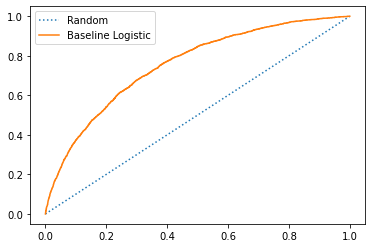

In [ ]:
plt.plot(rand_fpr, rand_tpr, linestyle='dotted', label='Random')
plt.plot(LR_base_fpr, LR_base_tpr, linestyle='solid', label='Baseline Logistic')
plt.legend()
print("Logistic Regression vs Random Assignment")
print("Logistic Regression: %.4f" % roc_auc_score(y_dev_og, LR_base_probs))
print("Random Assignment: %.4f" % roc_auc_score(y_dev_og, random_prob))

Logistic Regression Dev AUCs
Baseline: 0.7540
+ New Features: 0.7550
+ New Features + Hyperparameter Optimization: 0.7699


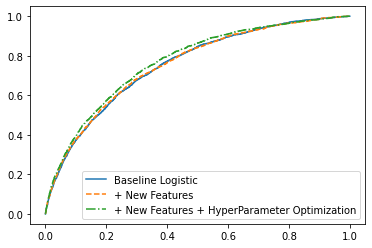

In [ ]:
plt.plot(LR_base_fpr, LR_base_tpr, linestyle='solid', label='Baseline Logistic')
plt.plot(LR_features_fpr, LR_features_tpr, linestyle='dashed', label='+ New Features')
plt.plot(LR_hyper_fpr, LR_hyper_tpr, linestyle='dashdot', label='+ New Features + HyperParameter Optimization')
plt.legend()

print("Logistic Regression Dev AUCs")
print("Baseline: %.4f" % roc_auc_score(y_dev_og, y_dev_og_probs))
print("+ New Features: %.4f" % roc_auc_score(y_dev_all_features, y_dev_all_features_probs))
print("+ New Features + Hyperparameter Optimization: %.4f" % roc_auc_score(y_dev_all_features,y_dev_all_features_hyper_probs))

In the above result, both adding new features and optimizing hyperparameter have a positive effect on AUC score. But adding new feature has a bigger impact. This suggest that if we want to improve the model further, more feature engineering would help.

We do not show our gridsearch outcomes here, but our final model is based on reviewing different:
1. Weights
2. Regularizations
3. Penalty types

We focsed on weights here, because our model is imbalanced. We found that none of the solutions we tried to improve the model balance led to better AUC. And so, we focused on overweighting the minority class (```TARGET == 1```). So, the penalty of wrong prediction of minority class will use weight of 91..the penalty of a wrong prediction of the minority class is 91x more severe. Referenced this [Medium post](https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b).

## Random Forest baseline + improvements

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier

#baseline
RF_baseline = RandomForestClassifier(n_jobs=-1)
RF_baseline.fit(X_train_og, y_train_og)

#all features 
RF_all_features = RandomForestClassifier(n_jobs=-1)
RF_all_features.fit(X_train_all_features, y_train_all_features)

#all features + hyperparameters
RF_all_features_hyper = RandomForestClassifier(n_estimators = 200, min_samples_split = 40, min_samples_leaf = 20,
                                               max_features = 50, class_weight ='balanced', criterion = 'entropy',
                                               random_state = 50, n_jobs = -1)
RF_all_features_hyper.fit(X_train_all_features, y_train_all_features)

CPU times: user 3h 51min 11s, sys: 15.6 s, total: 3h 51min 27s
Wall time: 16min 2s


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=50, min_samples_leaf=20,
                       min_samples_split=40, n_estimators=200, n_jobs=-1,
                       random_state=50)

Random Forest Dev AUCs
Baseline: 0.7124
+ New Features: 0.7179
+ New Features + Hyperparameter Optimization: 0.7642


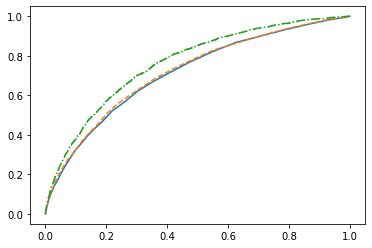

In [ ]:
RF_base_pred = RF_baseline.predict(X_dev_og)
RF_features_pred = RF_all_features.predict(X_dev_all_features)
RF_hyper_pred = RF_all_features_hyper.predict(X_dev_all_features)
RF_base_probs = RF_baseline.predict_proba(X_dev_og)[:,1]
RF_features_probs = RF_all_features.predict_proba(X_dev_all_features)[:,1]
RF_hyper_probs = RF_all_features_hyper.predict_proba(X_dev_all_features)[:,1]
RF_base_pr, RF_base_tpr, _ = roc_curve(y_dev_og, RF_base_probs)
RF_features_fpr, RF_features_tpr, _ = roc_curve(y_dev_all_features, RF_features_probs)
RF_hyper_fpr, RF_hyper_tpr, _ = roc_curve(y_dev_all_features, RF_hyper_probs)
# plot the roc curve for the model
plt.plot(RF_base_pr, RF_base_tpr, linestyle='solid', label='Baseline')
plt.plot(RF_features_fpr, RF_features_tpr, linestyle='dashed', label='+ New Features')
plt.plot(RF_hyper_fpr, RF_hyper_tpr, linestyle='dashdot', label='+ New Features + HyperParameter Optimization')
print("Random Forest Dev AUCs")
print("Baseline: %.4f" % roc_auc_score(y_dev_og, RF_base_probs))
print("+ New Features: %.4f" % roc_auc_score(y_dev_all_features, RF_features_probs))
print("+ New Features + Hyperparameter Optimization: %.4f" % roc_auc_score(y_dev_all_features,RF_hyper_probs))

In the above result, adding new features and optimizing hyperparameter both have positive effects on AUC score. Unexpectedly, the hyperparameter optimization has the biggest impact on the model performance. The reason is that Random Forest is very sensitive to imbalanced dataset (only 8% of our training data is class of 1). To correct for the class imbalance, we change the class weight to 'balanced' in the hyperparameter and result shows signficant improvement in the model performance. 

Compare to logisitic regression, an optimized random forest was able to produce similar result, but at a much, much slower speed. Therefore, it is not recommended.

## Light GBM baseline + improvements

In [ ]:
%%time

from lightgbm import LGBMClassifier

# baseline
LGBM_baseline = LGBMClassifier(n_jobs=-1)
LGBM_baseline.fit(X_train_og, y_train_og)

# all features
LGBM_all_features = LGBMClassifier(n_jobs=-1)
LGBM_all_features.fit(X_train_all_features, y_train_all_features)

# all features + hyperparameters
LGBM_all_features_hyper = LGBMClassifier(n_estimators=600, boosting_type='gbdt', metric='binary_logloss', objective = 'binary',
                                          class_weight = 'balanced', num_leaves=20, max_depth =-1,
                                          learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.8, 
                                          subsample = 0.8, n_jobs = -1, random_state = 50)
LGBM_all_features_hyper.fit(X_train_all_features, y_train_all_features)

gc.collect()

Dev AUCs
Baseline LGBM: 0.7608
+ New Features : 0.7802
+ New Features + Hyperparameter Optimization: 0.7834
CPU times: user 3min 54s, sys: 1min 15s, total: 5min 10s
Wall time: 20.4 s


LGBM Dev AUCs
Baseline: 0.7608
+ New Features: 0.7802
+ New Features + Hyperparameter Optimization: 0.7834


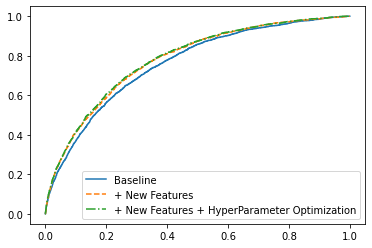

In [ ]:
LGBM_base_pred = LGBM_baseline.predict(X_dev_og)
LGBM_features_pred = LGBM_all_features.predict(X_dev_all_features)
LGBM_hyper_pred = LGBM_all_features_hyper.predict(X_dev_all_features)
LGBM_base_probs = LGBM_baseline.predict_proba(X_dev_og)[:,1]
LGBM_features_probs = LGBM_all_features.predict_proba(X_dev_all_features)[:,1]
LGBM_hyper_probs = LGBM_all_features_hyper.predict_proba(X_dev_all_features)[:,1]
LGBM_base_fpr, LGBM_base_tpr, _ = roc_curve(y_dev_og, LGBM_base_probs)
LGBM_features_fpr, LGBM_features_tpr, _ = roc_curve(y_dev_all_features, LGBM_features_probs)
LGBM_hyper_fpr, LGBM_hyper_tpr, _ = roc_curve(y_dev_all_features, LGBM_hyper_probs)
# plot the roc curve for the model
plt.plot(LGBM_base_fpr, LGBM_base_tpr, linestyle='solid', label='Baseline')
plt.plot(LGBM_features_fpr, LGBM_features_tpr, linestyle='dashed', label='+ New Features')
plt.plot(LGBM_hyper_fpr, LGBM_hyper_tpr, linestyle='dashdot', label='+ New Features + HyperParameter Optimization')
plt.legend()
print("LGBM Dev AUCs")
print("Baseline: %.4f" % roc_auc_score(y_dev_og, LGBM_base_probs))
print("+ New Features: %.4f" % roc_auc_score(y_dev_all_features, LGBM_features_probs))
print("+ New Features + Hyperparameter Optimization: %.4f" % roc_auc_score(y_dev_all_features,LGBM_hyper_probs))

In the above result, adding new features and optimizing hyperparameter both have positive effects on the AUC score. Similarly to logistic regression, add new feature has bigger effect on the final model performance. This  suggests adding more features would help model performance further. 

Compared to the other two models, LGBM achieves the highest AUC on the dev set. Therefore, it is the best of 3 models for this problem and if we were competing, we would come up with our test predictions using this model for the submission.

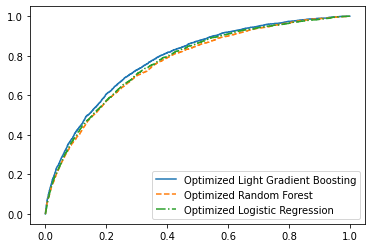

In [ ]:
plt.plot(LGBM_hyper_fpr, LGBM_hyper_tpr, linestyle='solid', label='Optimized Light Gradient Boosting')
plt.plot(RF_hyper_fpr, RF_hyper_tpr, linestyle='dashed', label='Optimized Random Forest')
plt.plot(LR_hyper_fpr, LR_hyper_tpr, linestyle='dashdot', label='Optimized Logistic Regression')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
from IPython.display import display

confusion_matrices = {
    'LR - Optimized': confusion_matrix(y_dev_all_features, LR_hyper_pred),
    'RF - Optimized': confusion_matrix(y_dev_all_features, RF_hyper_pred),
    'LGBM - Optimized': confusion_matrix(y_dev_all_features, LGBM_hyper_pred)
}

for k, v in confusion_matrices.items():
    print(k)
    tn, fp, fn, tp = v.ravel()
    print('Precision: {}'.format(tp/(tp+fp)))
    print('Recall: {}\n'.format(tp/(tp+fn)))

LR - Optimized
Precision: 0.18968715221961172
Recall: 0.6180499597099114

RF - Optimized
Precision: 0.3062930186823992
Recall: 0.2510072522159549

LGBM - Optimized
Precision: 0.1884920634920635
Recall: 0.6889605157131345



When comparing the confusion matrices as an additional information metric, we see that the optimized LR and LGBM both favor Recall over Precision, with LGBM slightly more lopsided, while RF is more balanced, slightly favoring Precision, but doesn't perform as well on either.  Having a higher recall in this case is associated with a higher ratio of true positives to false negatives vs. true positives to false positives, which would imply a conservative approach (i.e., predicting more false positives as opposed to a model with a higher precision).

#Final Evaluation of Optimized Models on Test Data

In [ ]:
# Logistic Regression
LR_all_features_hyper = LogisticRegression(C=9, class_weight={0: 10, 1: 90}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
LR_all_features_hyper.fit(X_train_all_features, y_train_all_features)

print("TEST AUCs")
print("Optimized Logistic Regression: %.4f" % roc_auc_score(y_test_all_features,\
                                                    LR_all_features_hyper.predict_proba(X_test_all_features)[:,1]))

# Random Forest
RF_all_features_hyper = RandomForestClassifier(n_estimators = 200, min_samples_split = 40, min_samples_leaf = 20,
                                               max_features = 50, class_weight ='balanced', criterion = 'entropy',
                                               random_state = 50, n_jobs = -1)
RF_all_features_hyper.fit(X_train_all_features, y_train_all_features)

print("Optimized Random Forest: %.4f" % roc_auc_score(y_test_all_features,\
                                                    RF_all_features_hyper.predict_proba(X_test_all_features)[:,1]))

# Light Gradient Boosting
LGBM_all_features_hyper = LGBMClassifier(n_estimators=600, boosting_type='gbdt', metric='binary_logloss', objective = 'binary',
                                          class_weight = 'balanced', num_leaves=20, max_depth =-1,
                                          learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.8, 
                                          subsample = 0.8, n_jobs = -1, random_state = 50)
LGBM_all_features_hyper.fit(X_train_all_features, y_train_all_features)

gc.collect()
print('Optimized Light Gradient Boosting: %.4f' %  roc_auc_score(y_test_all_features,\
                                                               LGBM_all_features_hyper.predict_proba(X_test_all_features)[:,1]))

TEST AUCs
Optimized Logistic Regression: 0.7639
Optimized Random Forest: 0.7626
Optimized Light Gradient Boosting: 0.7798


As expected, all models' performance dropped when evaluated on the test data, because we were overfitting our hyperparameters to our dev data. Therefore, only performance on our test data should be used as an expectation of our score in the comptition. Based on our test data result, light gradient boosting still outperforms the other two models. It also has the least drop in performance on test data, suggesting it is more resilient to overfitting on dev data than other two methods. Therefore, we will use light gradient boosting method in our final submission (not shown), if we were to compete.    


# Discussion

## What Worked

Our model evaluation suggests that both **adding new features** and **tweaking hyperparameters** improve the model performance. 

Initially we suspect that adding too many features would cause overfitting, however in practice that is not the case because each model has its own hyper parameter that deals with overfitting. Therefore, adding useless features doesn't hurt the model performance except computing speed. 

## What Didn't Work

**Undersampling** - while undersampling solves the issue with imbalanced label, it also drastically reduced our sample size. Because in this case we have a lot of features, we need more samples to accurately use the information from the features. 

**Oversampling** - Synthetic Minority Oversampling Technique (SMOTE) was used to oversample the data (sample code in appendix). While it both solve the issue with imbalanced data and generate more samples from the original data, it suffers from the curse of dimensionality. Because we have a lot of features, it is just as likely for SMOTE to generate noise or worse misleading data as good data. As result SMOTE are more likily to overfit than original data. 

**Feature Selection** - Several feature selection methods were selected: PCA, L1 penalty, coefficient or information gain metrics, sample code shown in appendix. At best they produce the same result as before, they don't improve AUC by reduce overfitting, because the algorithms we evaluated already have built-in hyperparameters that help to control overfitting. 

**Polynomials** - Polynomials were used on features with most information gain, sample code in appendix. The results were mixed, while it helped the logistic regression model, it didn't help decision type models. Worried that it was produce positive result by chance, we decided not to use it in the end. However, it is possible when apply differently, polynomial could still work. 

# Conclusion

In this project, we learned how to build a machine learning model for a large, complicated, real life dataset. We also learned how to improve model performance for logistic regression, random forest, and light GBM. Specificially, we learned that feature engineering works the best at improving the model performance. Therefore, if we were to compete in this competition in real life, we would spend much more time doing feature engineering in order to compete. 

At the same time, we were also humbled by the fact that the leading teams have much higher AUCs (0.81+) than us (~0.78). There must be some ways that improve the model, which we haven't tried it. For example, they may found a way to make polynomials work better or include more or better engineered features. We hope to learn more of these techniques in the coming semesters. 

# Appendix

## Sample Code for Error Analysis

In [ ]:
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))

#     axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
#     axes[0].set_xlabel("Training examples")
#     axes[0].set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes,
#                        return_times=True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

#     # Plot learning curve
#     axes[0].grid()
#     axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes[0].legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, 'o-')
#     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
#                          fit_times_mean + fit_times_std, alpha=0.1)
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

#     return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = X_train, y_train

# title = "Learning Curves (LR with Poly)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

# estimator = LR(solver='liblinear')
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.65, 0.95),
#                     cv=cv, n_jobs=4)

# X, y = X_resampled, y_resampled

# title = "Learning Curves (LR with Poly with FS)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

# estimator = LR(solver='liblinear')
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.65, 0.95),
#                     cv=cv, n_jobs=4)


# plt.show()

## Sample Code for Feature Selection and Polynomials

In [ ]:
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier as RF
# from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.linear_model import LogisticRegression as LR
# from sklearn.neural_network import MLPClassifier as MLP
# from sklearn.metrics import roc_auc_score
# from sklearn.feature_selection import SelectFromModel

# estimator = LR(solver='liblinear')

# selector = SelectFromModel(estimator,threshold=0.75*0.6440).fit(X_resampled, y_resampled)
# print("Avg coefficient and threshold for feature selection",selector.threshold_)

In [ ]:
# X_resampled_fs = selector.transform(X_resampled)
# X_train_fs = selector.transform(X_train)
# X_dev_fs = selector.transform(X_dev)
# X_test_fs = selector.transform(X_test)
# print("%3.0f features before feature selection"%(X_train.shape[1]))
# print("%3.0f features after feature selection"%(X_train_fs.shape[1]))

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# import gc
# gc.collect()

# # Create the polynomial object with specified degree
# poly_transformer = PolynomialFeatures(degree = 2)
# poly_transformer.fit(X_resampled_fs)

# # Transform the features
# X_resampled_fs_poly = poly_transformer.transform(X_resampled_fs)
# X_train_fs_poly = poly_transformer.transform(X_train_fs)
# X_dev_fs_poly = poly_transformer.transform(X_dev_fs)
# X_test_fs_poly = poly_transformer.transform(X_test_fs)
# print('Polynomial Features shape: ', X_train_fs_poly.shape)

In [ ]:
# estimator = LR(solver='liblinear')
# selector = SelectFromModel(estimator).fit(X_resampled_fs_poly, y_resampled)
# print("Avg coefficient and threshold for feature selection",selector.threshold_)

# X_resampled_fs_poly_fs = selector.transform(X_resampled_fs_poly)
# X_train_fs_poly_fs = selector.transform(X_train_fs_poly)
# X_dev_fs_poly_fs = selector.transform(X_dev_fs_poly)
# X_test_fs_poly_fs = selector.transform(X_test_fs_poly)
# print("%3.0f features after feature selection"%(X_train_fs_poly_fs.shape[1]))

## Sample Code For HyperParameter Optimization

In [ ]:
# %%time 

# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier as RF
# from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.linear_model import LogisticRegression as LR
# from sklearn.neural_network import MLPClassifier as MLP
# from sklearn.metrics import roc_auc_score

# c_values = [i*0.1 for i in range(1,200)]
# AUC_list = []
# #print("C Value",", ","AUC-Score")
# for c in c_values:
#     clf = LR(C = c, solver='liblinear')
#     clf.fit(mini_train_data, mini_train_labels)
#     #pred = clf.predict(X_dev)
#     AUC_score = roc_auc_score(y_dev,  clf.predict_proba(X_dev_fs_poly_fs)[:,1])
#     AUC_list.append(AUC_score)
#     #print(c, round(AUC_score,4))

# # Identifying the maximum value of F1 and its respective 'C' value:
# max_AUC = max(AUC_list)
# index = AUC_list.index(max_AUC)
# best_c = index/10

# print("The best value of C is: ", best_c, "Max AUC-score: ", round(max_AUC,4)) 


## Sample Oversample and Undersample Code

In [ ]:
# from imblearn.over_sampling import SMOTENC
# sm = SMOTE(random_state=42)

# X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# gc.collect
# print(f'''Shape of X before SMOTE: {X_train.shape}
# Shape of X after SMOTE: {X_resampled.shape}''')

# print('\nBalance of positive and negative classes (%):')
# print(y_train.value_counts(normalize=True) * 100)

# print('\nBalance of positive and negative classes (%):')
# print(y_resampled.value_counts(normalize=True) * 100)

In [ ]:
# from sklearn.model_selection import train_test_split


# positives = df.TARGET == 1
# negatives = ~positives
# neg_df = df.loc[negatives]
# balanced_df = pd.concat([neg_df.sample(sum(positives)),df.loc[positives]])
# y = balanced_df.TARGET
# X = balanced_df.drop('TARGET',axis=1)

# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X, y, test_size=0.10, random_state=42, stratify=y)
# X_train_raw, X_dev_raw, y_train, y_dev = train_test_split(
#     X_train_raw, y_train, test_size=1/9., random_state=42, 
#     stratify=y_train)

## Sample Imputation Methods


In [ ]:
# def get_impute_knn_score(X_missing, y_missing):
#     imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors = 5)
#     knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
#     return knn_impute_scores.mean(), knn_impute_scores.std()


# mse, stds = get_impute_knn_score(
#     X_train_impute[num_features], y_train_impute)
# on 24,600 records and all features the wall time was > 1 hr; prohibitively difficult to run 

## Sample Code for Incremental PCA

In [ ]:
# from sklearn.decomposition import IncrementalPCA
# from tqdm.notebook import tqdm

# pca = transformer = IncrementalPCA(batch_size=1000)
# nbatch = len(X2_train)//200
# for i in tqdm(range(nbatch)):
#     if i < nbatch - 1:
#         pca.partial_fit(X2_train[i*200:i*200+200,:])
#     else:
#         pca.partial_fit(X2_train[i*200:,:])
# pca.explained_variance_ratio_.cumsum()
# X2_train_pc = pca.transform(X2_train)
# X2_dev_pc = pca.transform(X2_dev)
# X2_test_pc = pca.transform(X2_test)
# print(X2_train_pc.shape)
# print(X2_train.shape)